In [6]:
import numpy as np
import random
import operator
import math
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import multivariate_normal

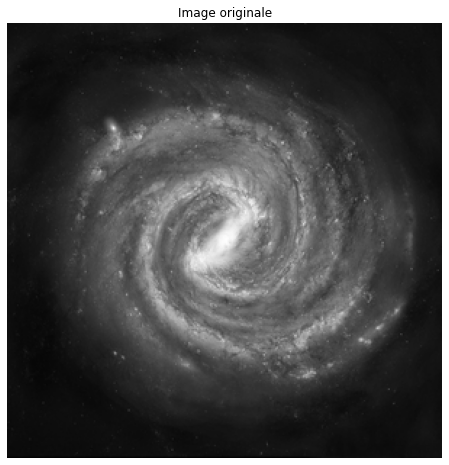

In [ ]:
image_path = './milky-way.jpg'
img = Image.open(image_path)

img = img.convert('RGB')

max_size = 300
img.thumbnail((max_size, max_size), Image.Resampling.LANCZOS)

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.title('Image originale')
plt.axis('off')
plt.show()

img_array = np.array(img)

original_shape = img_array.shape
height, width = original_shape[0], original_shape[1]

if len(img_array.shape) == 3: 
    df = img_array.reshape(-1, 3) 
    feature_names = ['Red', 'Green', 'Blue']
else:
    df = img_array.reshape(-1, 1)  
    feature_names = ['Gray']

In [8]:
# Nombre de clusters
k = 5

# Paramètre de flou (m)
m = 2.00 

# Critère d'arrêt
MAX_ITER = 100  
epsilon = 0.01 

print(f"  - Nombre de clusters: {k}")
print(f"  - Paramètre de flou (m): {m}")
print(f"  - Itérations max: {MAX_ITER}")
print(f"  - Epsilon: {epsilon}")

  - Nombre de clusters: 5
  - Paramètre de flou (m): 2.0
  - Itérations max: 100
  - Epsilon: 0.01


# **Initialisation des centres des clusters**

In [9]:
def initializeMembershipMatrix(n, k):
    """Initialise la matrice d'appartenance de manière aléatoire"""
    membership_mat = np.random.rand(n, k)
    membership_mat = membership_mat / membership_mat.sum(axis=1, keepdims=True)
    return membership_mat

def calculateClusterCenter(membership_mat, m, df):
    """Calcule les centres des clusters"""
    membership_mat_powered = membership_mat ** m
    cluster_centers = []
    
    for j in range(membership_mat.shape[1]):
        numerator = (membership_mat_powered[:, j:j+1] * df).sum(axis=0)
        denominator = membership_mat_powered[:, j].sum()
        center = numerator / denominator
        cluster_centers.append(center)
    
    return np.array(cluster_centers)

def updateMembershipValue(membership_mat, cluster_centers, m, df):
    """Met à jour les valeurs d'appartenance"""
    n = df.shape[0]
    k = len(cluster_centers)
    distances = np.zeros((n, k))
    for j in range(k):
        distances[:, j] = np.linalg.norm(df - cluster_centers[j], axis=1)
    distances = np.where(distances == 0, 1e-10, distances)
    power = 2 / (m - 1)
    for i in range(n):
        for j in range(k):
            denominator = sum([(distances[i, j] / distances[i, c]) ** power 
                              for c in range(k)])
            membership_mat[i, j] = 1 / denominator
    
    return membership_mat

n = df.shape[0]  # nombre de pixels
membership_mat = initializeMembershipMatrix(n, k)
print(f"Matrice d'appartenance initialisée: {membership_mat.shape}")

Matrice d'appartenance initialisée: (90000, 5)


# **Exécution de l'algorithme Fuzzy C-Means**

In [10]:
iteration = 0
converged = False

print("Début de l'algorithme Fuzzy C-Means...")

while iteration < MAX_ITER and not converged:
    # Sauvegarder l'ancienne matrice pour vérifier la convergence
    old_membership_mat = membership_mat.copy()
    
    # Calculer les centres des clusters
    Centers = calculateClusterCenter(membership_mat, m, df)
    
    # Mettre à jour la matrice d'appartenance
    membership_mat = updateMembershipValue(membership_mat, Centers, m, df)
    
    # Vérifier la convergence
    diff = np.linalg.norm(membership_mat - old_membership_mat)
    
    iteration += 1
    
    if iteration % 10 == 0:
        print(f"Itération {iteration}: différence = {diff:.6f}")
    
    if diff < epsilon:
        converged = True
        print(f"\nConvergence atteinte à l'itération {iteration}")

if not converged:
    print(f"\nNombre maximum d'itérations atteint: {MAX_ITER}")

final_weights = membership_mat
print(f"\nCentres finaux des clusters:")
for i, center in enumerate(Centers):
    print(f"  Cluster {i+1}: {center}")

Début de l'algorithme Fuzzy C-Means...
Itération 10: différence = 21.613486
Itération 20: différence = 5.868667
Itération 30: différence = 2.637633
Itération 40: différence = 1.225853
Itération 50: différence = 0.585874
Itération 60: différence = 0.284508
Itération 70: différence = 0.139290
Itération 80: différence = 0.068471
Itération 90: différence = 0.033725
Itération 100: différence = 0.016628

Nombre maximum d'itérations atteint: 100

Centres finaux des clusters:
  Cluster 1: [19.35985019]
  Cluster 2: [50.86775722]
  Cluster 3: [87.33854184]
  Cluster 4: [182.02382782]
  Cluster 5: [122.79657928]


# **Reconstruction et visualisation de l'image segmentée**

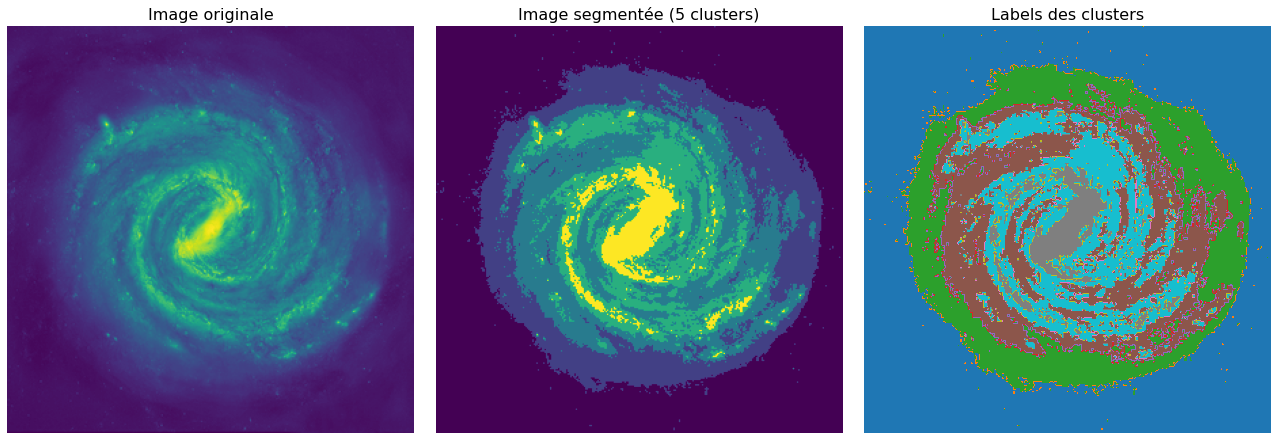

In [11]:
# Assigner chaque pixel au cluster avec la plus haute appartenance
cluster_assignments = np.argmax(final_weights, axis=1)

# Créer l'image segmentée en utilisant les centres des clusters
segmented_image = Centers[cluster_assignments]

# Reshape pour retrouver les dimensions originales
if len(original_shape) == 3:
    segmented_image = segmented_image.reshape(height, width, 3)
else:
    segmented_image = segmented_image.reshape(height, width)

# Convertir en uint8 pour l'affichage
segmented_image = np.clip(segmented_image, 0, 255).astype(np.uint8)

# Afficher les résultats
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Image originale
axes[0].imshow(img)
axes[0].set_title('Image originale', fontsize=16)
axes[0].axis('off')

# Image segmentée
axes[1].imshow(segmented_image)
axes[1].set_title(f'Image segmentée ({k} clusters)', fontsize=16)
axes[1].axis('off')

# Labels des clusters
cluster_labels = cluster_assignments.reshape(height, width)
axes[2].imshow(cluster_labels, cmap='tab10')
axes[2].set_title('Labels des clusters', fontsize=16)
axes[2].axis('off')

plt.tight_layout()
plt.show()

# **Visualisation avec Carte de Chaleur (Heatmap)**

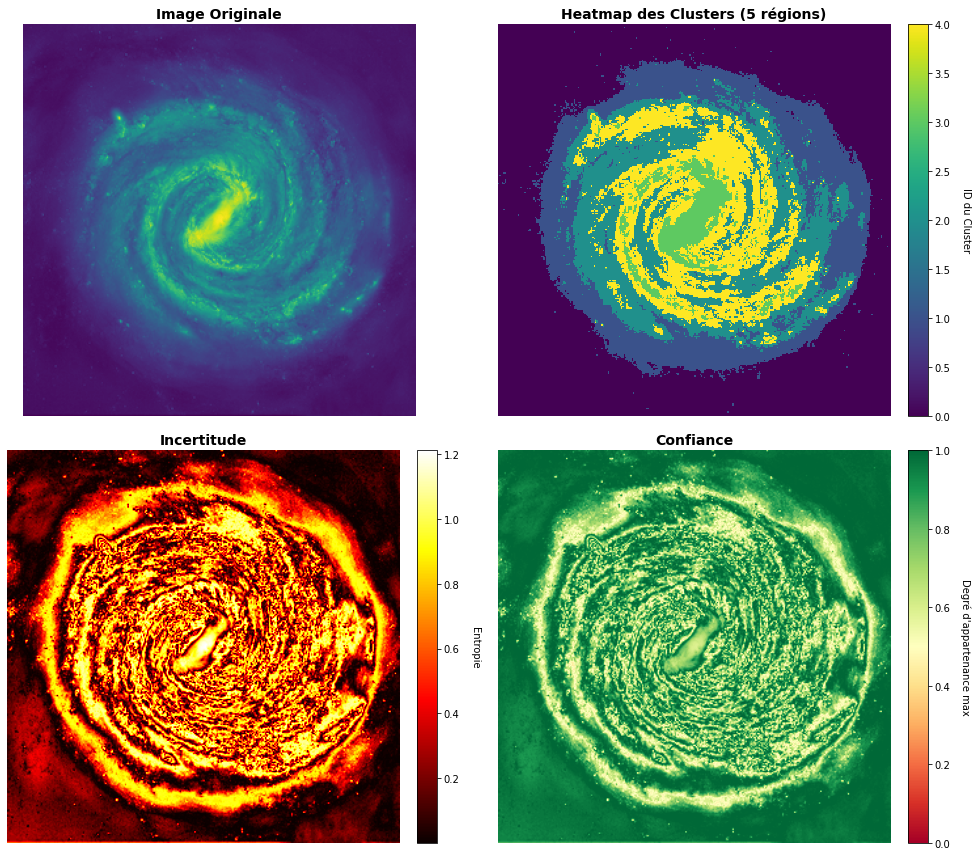

In [12]:
import matplotlib.colors as mcolors

fig = plt.figure(figsize=(20, 12))

#1
ax1 = plt.subplot(2, 3, 1)
ax1.imshow(img)
ax1.set_title('Image Originale', fontsize=14, fontweight='bold')
ax1.axis('off')

#2
ax2 = plt.subplot(2, 3, 2)
im2 = ax2.imshow(cluster_labels, cmap='viridis', interpolation='nearest')
ax2.set_title(f'Heatmap des Clusters ({k} régions)', fontsize=14, fontweight='bold')
ax2.axis('off')
cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
cbar2.set_label('ID du Cluster', rotation=270, labelpad=20)



#3
ax3 = plt.subplot(2, 3, 4)
epsilon_entropy = 1e-10
entropy = -np.sum(final_weights * np.log(final_weights + epsilon_entropy), axis=1)
entropy_map = entropy.reshape(height, width)
im3 = ax3.imshow(entropy_map, cmap='hot', interpolation='bilinear')
ax3.set_title('Incertitude', fontsize=14, fontweight='bold')
ax3.axis('off')
cbar4 = plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
cbar4.set_label('Entropie', rotation=270, labelpad=20)

#4
ax4 = plt.subplot(2, 3, 5)
max_membership = np.max(final_weights, axis=1).reshape(height, width)
im4 = ax4.imshow(max_membership, cmap='RdYlGn', vmin=0, vmax=1, interpolation='bilinear')
ax4.set_title('Confiance', fontsize=14, fontweight='bold')
ax4.axis('off')
cbar5 = plt.colorbar(im4, ax=ax4, fraction=0.046, pad=0.04)
cbar5.set_label('Degré d\'appartenance max', rotation=270, labelpad=20)



plt.tight_layout()
plt.show()

# **Visualisation des clusters individuels**

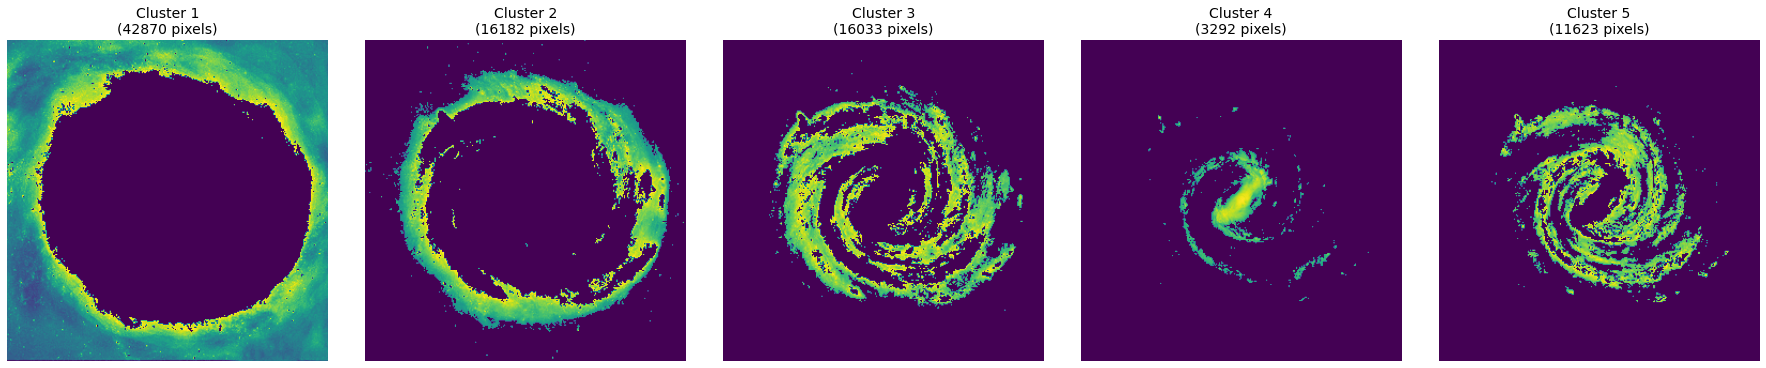


Statistiques des clusters:
Cluster 1: 42870 pixels (47.63%)
Cluster 2: 16182 pixels (17.98%)
Cluster 3: 16033 pixels (17.81%)
Cluster 4: 3292 pixels (3.66%)
Cluster 5: 11623 pixels (12.91%)


In [13]:
# Afficher chaque cluster séparément
fig, axes = plt.subplots(1, k, figsize=(5*k, 5))

if k == 1:
    axes = [axes]

for i in range(k):
    # Créer un masque pour le cluster i
    mask = (cluster_labels == i)
    cluster_image = img_array.copy()
    
    # Mettre en noir les pixels qui ne sont pas dans ce cluster
    if len(original_shape) == 3:
        cluster_image[~mask] = [0, 0, 0]
    else:
        cluster_image[~mask] = 0
    
    axes[i].imshow(cluster_image)
    axes[i].set_title(f'Cluster {i+1}\n({mask.sum()} pixels)', fontsize=14)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Afficher les statistiques de chaque cluster
print("\nStatistiques des clusters:")
for i in range(k):
    n_pixels = (cluster_assignments == i).sum()
    percentage = (n_pixels / len(cluster_assignments)) * 100
    print(f"Cluster {i+1}: {n_pixels} pixels ({percentage:.2f}%)")